# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Rodrigo Martín del Campo

**Project Name:** US Elections

**Professor**: Pablo Camarillo Ramirez

# Introduction

In this project, I address the challenges of managing, transforming, and analyzing large volumes of electoral data spanning multiple decades. The dataset used contains information from United States presidential elections between 1976 and 2020, including vote counts by candidate, party affiliation, and state-level results. This dataset was chosen because it provides rich historical data for analysis and prediction, and it was more complete and accessible than equivalent Mexican election datasets, which lacked the necessary structure and consistency for this type of processing.

The main objective of this project is to design a robust data pipeline capable of ingesting, cleaning, and transforming electoral data to enable clear visualization and meaningful insights. By integrating electoral data with Electoral College information, the final processed dataset can serve as the foundation for interactive dashboards and predictive models. These models could forecast potential election outcomes based on historical trends, while dashboards would provide readable and intuitive summaries of party performance, vote distribution, and state-level changes over time.

# Dataset

### Data model

The data model I will use in this project is **relational**.

The pipeline will consolidate **US presidential election results** with it's corresponding and relevant information, and join it with data regarding **electoral college votes** per state, which is relevant information to determine presidency winners in the US.  

The final processed data will be persisted in **PostgreSQL**, chosen because:
- The main operations involve filtering, grouping, and aggregating for which SQL fits perfectly.
- Because the data isn't expected to require high frequency writes (added information would be expected every 4 years because of it's nature) a NoSQL solution could add unnecessary complexity.
- It provides data integrity through strict typing.
- It is easy to connect with BI tools or dashboards later on.

### Data schema

The project is based on two main datasets: one containing U.S. presidential election results from 1976 to 2020, and another with Electoral College votes per state. The former extracted from MIT's Election Lab and Harvard's Dataverse, and the latter from ReadySignal.

The elections dataset includes information such as the year, state, candidate names, political party, and the number of votes each candidate received. The Electoral College dataset provides the number of votes each state contributes to the national election.

The plan is to join both datasets using the state and state abbreviation columns. This will allow the final dataset to include not only the popular vote data but also the Electoral College information for a more complete analysis.

The goal is to create a clean and structured dataset that can be used for visualizations and predictive analysis. By transforming and simplifying the data, we can easily generate dashboards that show voting patterns, trends, and results over time.

### Datasets sources

1976-2020 Presidency Elections Results: _https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/42MVDX_

Electoral College Votes: _https://www.readysignal.com/electoral-college-data-table/_

# Transformations and Actions

### Importing required libraries and creating the Spark session

In [1]:
import findspark
findspark.init()

from martindelcampo.spark_utils import SparkUtils
from pyspark.sql import SparkSession
from pyspark.sql.functions import trim, col, count, isnull, when, lit, concat, avg, upper
from pyspark.sql import functions as F
from pyspark.sql.window import Window

spark = SparkSession.builder \
    .appName("FinalProject_BatchProcessing") \
    .master("spark://d1fd305c6e3b:7077") \
    .config("spark.jars", "/opt/spark/work-dir/jars/postgresql-42.7.8.jar") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

25/10/28 01:37:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Create the schemas

In [2]:
# Column definition
elections_schema_columns = [
    ("year", "int"),
    ("state", "string"),
    ("state_po", "string"),
    ("state_fips", "int"),
    ("state_cen", "int"),
    ("state_ic", "int"),
    ("office", "string"),
    ("candidate", "string"),
    ("party_detailed", "string"),
    ("writein", "boolean"),
    ("candidatevotes", "int"),
    ("totalvotes", "int"),
    ("version", "int"),
    ("notes", "string"),
    ("party_simplified", "string")
]

# Generate schema with my method
elections_schema = SparkUtils.generate_schema(elections_schema_columns)

# Column definition for electoral college votes
ec_schema_columns = [
    ("state", "string"),                      
    ("state_po", "string"),                 
    ("electoral_college_votes", "int")      
]

# Generate its Schema
ec_schema = SparkUtils.generate_schema(ec_schema_columns)


### Loading the datasets

In [3]:
df_elections = spark.read \
                .option("header", "true") \
                .schema(elections_schema) \
                .csv("/opt/spark/work-dir/data/us_presidential_elections/")

df_electoral_college = spark.read \
                .option("header", "true") \
                .schema(ec_schema) \
                .csv("/opt/spark/work-dir/data/electoral_college_votes/")

### Transformations

#### Cleaning the Electoral College Votes dataset

In [4]:
# I will start by transforming the electoral college votes df since it's very straightforward
# I wil join this dataframe since I'm interested in the amount of electoral college votes of each state,
# this information will be useful to predict presidential winners, since the system in the US is made so that whoever has
# more electoral college votes wins the election, not whoever has more overall votes. I'm only interested in the column
# with the number of electoral vote and the state abbreviation since I will use it to join it to the other df

df_electoral_college = df_electoral_college.drop("state")

#### Cleaning the Elections dataset

In [5]:
# Drop 'state_fips', 'state_cen', and 'state_ic'
# These are numerical identifiers for states that aren't needed for this analysis.
# I will assign my own numeric identifiers if needed later.
df_elections = df_elections.drop("state_fips", "state_cen", "state_ic")

# Drop 'office'
# It's unnecessary since all records represent presidential votes (already implicit).
df_elections = df_elections.drop("office")

# Drop 'writein'
# Write-in votes are irrelevant for this project since they don't impact major results.
df_elections = df_elections.drop("writein")

# Drop 'version'
# This column only indicates when new information was added; it has no analytical value here.
df_elections = df_elections.drop("version")

# Drop 'notes'
# This column contains only NA/NULL values and adds no useful information.
df_elections = df_elections.drop("notes")

# Drop 'party_simplified'
# I will create my own simplified classification from 'party_detailed'.
# Realistically, only DEMOCRAT, REPUBLICAN, or OTHER categories are needed.
df_elections = df_elections.drop("party_simplified")

#### Normalizations, mappings, consolidations, aggregations, and even window transformations of the Elections dataset

In [6]:
# Create a window ordered alphabetically by state name
# A window in Spark lets us apply functions like row_number(), rank(), lag(), or sum()
# over a specific ordered set of rows without grouping the entire DataFrame.
# Here we order globally by "state" (no partition), so functions can see the sequence
# of states alphabetically. This is useful for ranking, comparisons, or running totals.
# I found out about window functions when looking for a way to rank candidates
# and compare rows without using groupBy—Spark's Window API makes that possible.
window_spec = Window.orderBy("state")

# Use dense_rank to assign an ID 1–50 for the 50 unique states
# dense_rank() ensures consecutive numbering without gaps
# I will do this since in the future, having numeric values to represent columns will be necessary
# I will not yet drop the clomun state since it might be useful when creating map dashboards
df_elections = df_elections.withColumn("state_id", F.dense_rank().over(window_spec))

# Normalize all text to uppercase and simplify to three categories:
# DEMOCRAT and REPUBLICAN stay as they are.
# All other parties (Libertarian, Green, Independent, etc.) will be grouped under "OTHER"
# because let's be real, it's always a race between republicans and democrats
df_elections = df_elections.withColumn(
    "party_detailed",
    when(upper(df_elections.party_detailed) == "DEMOCRAT", "DEMOCRAT")
    .when(upper(df_elections.party_detailed) == "REPUBLICAN", "REPUBLICAN")
    .otherwise("OTHER")
)

# More complicated transformation: I will collapse minor parties into a single OTHER row
# 1) Force any non-DEM/REP candidate name to "OTHER" (so grouping will collapse them)
df_elections_collapsed = df_elections.withColumn(
    "candidate",
    F.when(F.col("party_detailed") == "OTHER", F.lit("OTHER")).otherwise(F.col("candidate"))
)

# 2) Aggregate to get at most 3 rows per (year, state): DEMOCRAT, REPUBLICAN, OTHER
#    - Sum candidatevotes for each party bucket (OTHER will sum all minor parties)
#    - Keep totalvotes as the state-year total (max is safe; it's the same across candidates for that state-year)
df_elections_collapsed = (
    df_elections_collapsed
    .groupBy(
        "year", "state", "state_po", "state_id",
        "party_detailed", "candidate"
    )
    .agg(
        F.sum("candidatevotes").alias("candidatevotes"),
        F.max("totalvotes").alias("totalvotes")
    )
)

# Assign numeric identifiers for each party:
# REPUBLICAN -> 0
# DEMOCRAT   -> 1
# OTHER      -> 2
# Mapping will simplify processes with the data later on
df_elections_collapsed = df_elections_collapsed.withColumn(
    "party_id",
    when(col("party_detailed") == "REPUBLICAN", 0)
    .when(col("party_detailed") == "DEMOCRAT", 1)
    .otherwise(2)
)

# I will define another window partitioned by year and state to compare each party's votes within that state/year
# this will help me define a new column "state_victory", which will contain true/false 0/1 values to know if the candidate
# won that state in that year and if he takes the electoral votes that I will join later on
window_spec = Window.partitionBy("year", "state")

# Determine which row (party) has the maximum votes in that state/year
df_elections_collapsed = df_elections_collapsed.withColumn(
    "state_victory",
    F.when(
        F.col("candidatevotes") == F.max("candidatevotes").over(window_spec),
        F.lit(1)  # 1 means this party won the state
    ).otherwise(F.lit(0))  # 0 means this party lost the state
)

#### Join presidential results and electoral college datasets and order the final dataframe

In [7]:
# Now I will perform the join between my two dataframes, adding the important values of "electoral_college_votes" to the election dataframe:
# Since electoral_college data is not static (meaning it has changed historically, this isn't great since those values have changed historically, but
# I couldn't find a dataset with year information, but these current electoral college points will be useful to model and predict victories in the
# next deliverables), we join only by 'state_po'.
df_elections_final = df_elections_collapsed.join(
    df_electoral_college.select("state_po", "electoral_college_votes"),
    on="state_po",
    how="left"
)

# Order the information by year, state, and party for easier data understanding when looking at the result table
df_elections_final = df_elections_final.orderBy("year", "state", "party_id")

# Persistence Data

### Database justification

The decision to use PostgreSQL is based on the nature and purpose of the datasets used in this project. Both the U.S. presidential elections data (1976–2020) and the Electoral College votes are structured and relational, making a SQL-based system the most appropriate choice.

**Key Reasons:**
- Structured Data: Each record contains clearly defined attributes such as year, state, party, and votes, which fit naturally into a relational model.
- Ease of Integration: Relational joins between state results and Electoral College votes are straightforward and efficient.
- Low Update Frequency: Since new data is only added every four years, a real-time or NoSQL system is unnecessary.
- Analytical Capability: PostgreSQL supports aggregations, queries, and visualization tools for dashboard creation.
- Reliability and Consistency: Ensures data integrity and long-term stability for historical datasets.

### Persist / Write to PostgreSQL

In [8]:
jdbc_url   = "jdbc:postgresql://postgres-iteso:5432/postgres"
table_name = "elections_1976_2020_with_ec"

(
    df_elections_final.write
      .format("jdbc")
      .option("url", jdbc_url)
      .option("dbtable", table_name)
      .option("user", "postgres")
      .option("password", "Admin@1234")
      .option("driver", "org.postgresql.Driver")
      .mode("overwrite")                 
      .save()
)

print(f"DataFrame successfully written into PostgreSQL table '{table_name}'!")

[Stage 3:>                                                          (0 + 1) / 1]

DataFrame successfully written into PostgreSQL table 'elections_1976_2020_with_ec'!


### Read/Actions to validate persistence

In [9]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
db_properties = {
    "user": "postgres",
    "password": "Admin@1234",
    "driver": "org.postgresql.Driver"
}

table_name = "elections_1976_2020_with_ec"

# Read the data back from PostgreSQL
df = spark.read.jdbc(url=jdbc_url, table=table_name, properties=db_properties)

# I can finally print the schema and execute a show action to validate this first deliverable of the project
df.printSchema()
df.show()

root
 |-- state_po: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- state_id: integer (nullable = true)
 |-- party_detailed: string (nullable = true)
 |-- candidate: string (nullable = true)
 |-- candidatevotes: long (nullable = true)
 |-- totalvotes: integer (nullable = true)
 |-- party_id: integer (nullable = true)
 |-- state_victory: integer (nullable = true)
 |-- electoral_college_votes: integer (nullable = true)

+--------+----+-----------+--------+--------------+-------------+--------------+----------+--------+-------------+-----------------------+
|state_po|year|      state|state_id|party_detailed|    candidate|candidatevotes|totalvotes|party_id|state_victory|electoral_college_votes|
+--------+----+-----------+--------+--------------+-------------+--------------+----------+--------+-------------+-----------------------+
|      AL|1976|    ALABAMA|       1|    REPUBLICAN| FORD, GERALD|        504070|   1182850|       0|     

# DAG

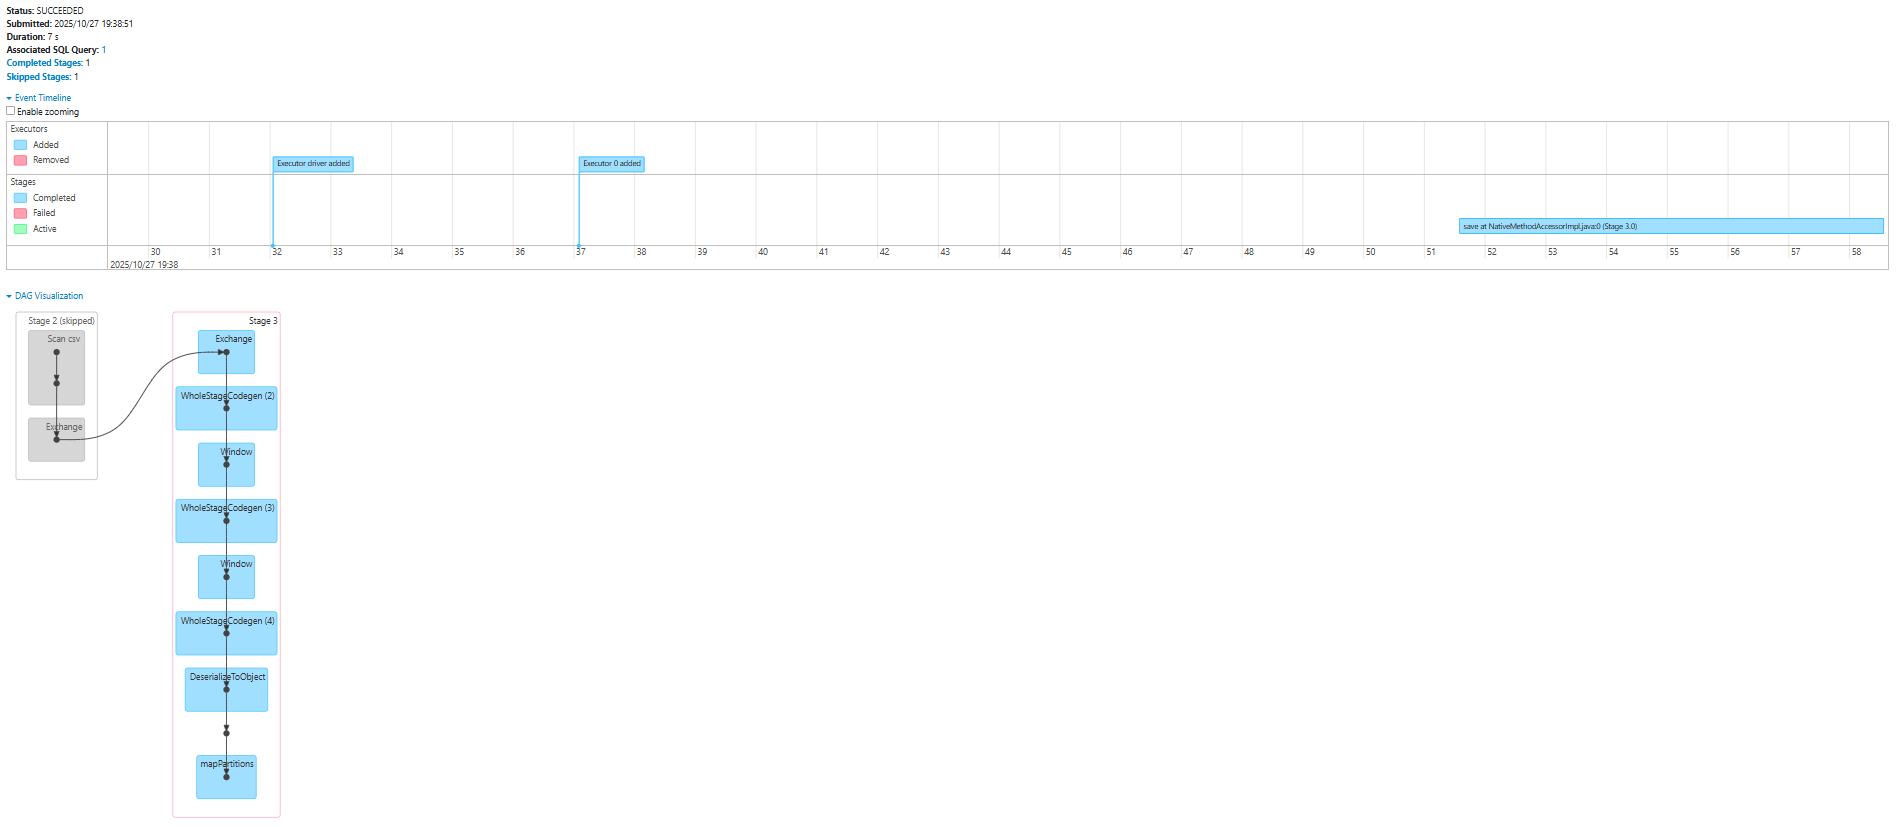

In [10]:
sc.stop()